In [ ]:
# default_exp data.event_preprocessing

## Event  Preprocessing
> Functions to extract signal regions corresponsing to events 

In [ ]:
#export
from tsai.imports import *
from tsai.utils import * 
from tsai.data.validation import *

In [ ]:
from tsai.data.synthetic import get_sample_data

In [ ]:
#exporti
def _sliding_events(all_events, sig_lengths, width=100, offset=None, limit=None, include_empty=False):
    offset = offset if offset else -width//2
    offsetR = width + offset
    for i, events in enumerate(all_events):
        length = sig_lengths if isinstance(sig_lengths, int) else sig_lengths[i]
        events =  [(idx, e) for idx, e in enumerate(events) 
                   if e+offset >=0 and e+offsetR <  length]  # trim overlap
        if len(events) > 0:
            if limit and len(events) > limit:
                random.shuffle(events)
                events = events[:limit]
            for i_e, e in events:
                yield i, e+offset, e+offsetR, i_e
        elif include_empty:
            e = random.randint(sig_lengths[i]-width)
            yield i, e, e+width, None
        else:
            continue

In [ ]:
#exporti
def _compute_new_splits(m, orig_splits):
    N = len(orig_splits)
    split_map = {i_orig:i_split for i_split, split in enumerate(orig_splits) for i_orig in split}
    return L([[i for i, i_orig in enumerate(m) if split_map[i_orig] == i_split]
              for i_split in range(N)])

In [ ]:
#exporti
def _compute_new_folds(m, orig_folds):
    return np.array([orig_folds[i] for i in m])

In [ ]:
#export
@delegates(_sliding_events)
def preprocess_sliding_event_window(X, y, events, 
                                    has_label_per_event=False, has_label_per_sample=False,
                                    splits=None, folds=None, **kwargs):
    """
Inputs:
      X: signal data, can be uniform or ragged, with or without channels 
      y: label data 
      events: List of event positions  for each signal  
      width: window size in samples
      offset: start of window vs event, window centered by default
      limit: max windows per signal
      has_label_per_event:  returns lavel data corresponsing to specific event
      has_label_per_sample: returns labels within window
      include_empty: include randomly selected window if no events
      splits: splits data, will be mapped to windows data if present
      folds:  folds data, will be mapped to windows data if present
      *note: splits and folds are mutually exclusive
Returns:
      X_win: windows signals 
      y_win: labels for windowed signals
      folds_win or folds_win: Optional, depending on if splits or folds specified
"""
    assert not (has_label_per_sample and 'include_empty' in kwargs and kwargs['include_empty']) ## not supported
    sig_lengths = X.shape[-1] if len(X.shape) > 1  else [x.shape[-1] for x in X]
    if has_label_per_event:
        X_win, y_win, m = zip(*[[X[i_orig][..., idx_l:idx_r], y[i_orig][i_e], i_orig]
            for (i_orig, idx_l, idx_r, i_e) in _sliding_events(events, sig_lengths, **kwargs)])
    elif has_label_per_sample:
        X_win, y_win, m = zip(*[[X[i_orig][..., idx_l:idx_r], y[i_orig][idx_l:idx_r], i_orig]
            for (i_orig, idx_l, idx_r, i_e) in _sliding_events(events, sig_lengths, **kwargs)])
    else:
        X_win, y_win, m = zip(*[[X[i_orig][..., idx_l:idx_r], y[i_orig], i_orig]
            for (i_orig, idx_l, idx_r, i_e) in _sliding_events(events, sig_lengths, **kwargs)])
    
    if not isinstance(splits, NoneType):
        return np.array(X_win), y_win, _compute_new_splits(m, splits)
    elif not isinstance(folds, NoneType):
        return np.array(X_win), y_win, _compute_new_folds(m, folds)
    else:
        return np.array(X_win), y_win

In [ ]:
help(preprocess_sliding_event_window)

Help on function preprocess_sliding_event_window in module __main__:

preprocess_sliding_event_window(X, y, events, has_label_per_event=False, has_label_per_sample=False, splits=None, folds=None, width=100, offset=None, limit=None, include_empty=False)
    Inputs:
          X: signal data, can be uniform or ragged, with or without channels 
          y: label data 
          events: List of event positions  for each signal  
          width: window size in samples
          offset: start of window vs event, window centered by default
          limit: max windows per signal
          has_label_per_event:  returns lavel data corresponsing to specific event
          has_label_per_sample: returns labels within window
          include_empty: include randomly selected window if no events
          splits: splits data, will be mapped to windows data if present
          folds:  folds data, will be mapped to windows data if present
          *note: splits and folds are mutually exclusive
   

#### Example: Uniform 1-d signal

X:(3, 1000)  y:3  events:3


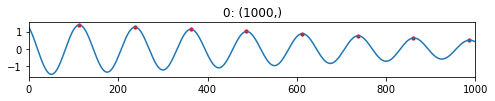

In [ ]:
X, y, events = get_sample_data(length=1000, n_sig=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')
i, sig = 0, X[0]

plt.figure(figsize=(8, 1))
plt.title(f'{i}: {sig.shape}')
plt.plot(np.arange(len(sig)), sig)
plt.scatter(events[i], sig[events[i]], c='r', s=10)
plt.xlim(0, len(sig))
plt.show()

X_win:(15, 150)  y_win:15


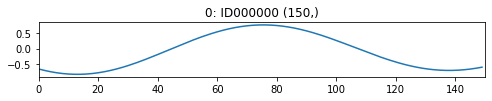

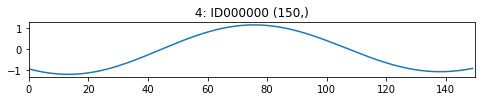

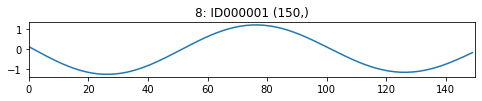

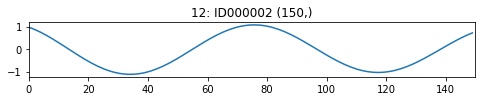

In [ ]:
X_win, y_win = preprocess_sliding_event_window(X, y, events, width=150, limit=5)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')

for i in range(0, len(X_win), 4):
    sig = X_win[i]
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {y_win[i]} {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show()  

#### Example: Uniform 2-d signal (includes channels)

In [ ]:
X, y, events = get_sample_data(length=1000, n_sig=3, dims=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')

X_win, y_win = preprocess_sliding_event_window(X, y, events, width=150, limit=5)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')

X:(3, 1, 1000)  y:3  events:3
X_win:(15, 1, 150)  y_win:15


#### Example: Ragged 1-d signal

X:(3,)  y:3  events:3


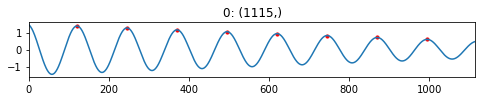

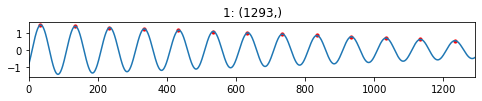

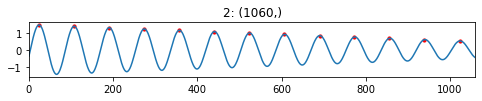

In [ ]:
X, y, events = get_sample_data(length=(1000, 2000), n_sig=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')
for i, sig in enumerate(X):
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.scatter(events[i], sig[events[i]], c='r', s=10)
    plt.xlim(0, len(sig))
    plt.show()

X_win:(15, 150)  y_win:15


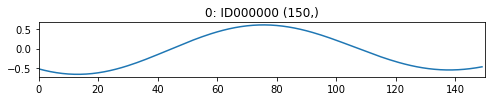

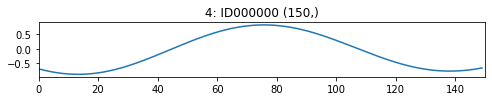

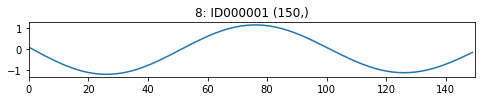

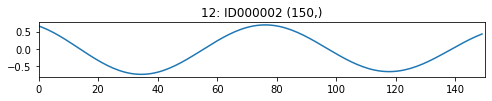

In [ ]:
X_win, y_win = preprocess_sliding_event_window(X, y, events, width=150, limit=5)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')
for i in range(0, len(X_win), 4):
    sig = X_win[i]
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {y_win[i]} {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show()    

#### Example: per-event labels

In [ ]:
X, _, events = get_sample_data(length=1000, n_sig=3)
y = [ [f'row{i}_e{e}' for e in events[i]] for i in range(len(X))]
y[0]

['row0_e102',
 'row0_e227',
 'row0_e352',
 'row0_e477',
 'row0_e602',
 'row0_e727',
 'row0_e852',
 'row0_e976']

X_win:(15, 150)  y_win:15


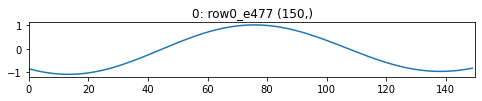

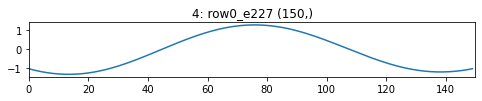

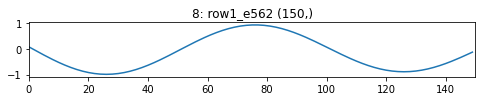

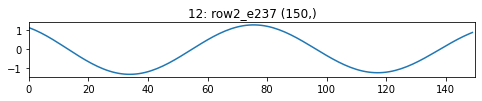

In [ ]:
X_win, y_win = preprocess_sliding_event_window(X, y, events, width=150, limit=5, has_label_per_event=True)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')
for i in range(0, len(X_win), 4):
    sig = X_win[i]
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {y_win[i]} {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show()  

#### Example: per-sample labels

In [ ]:
X, _, events = get_sample_data(length=1000, n_sig=3)
y = []
for i, row_events in enumerate(events):
    row_y = np.zeros((X[i].shape[-1]), dtype=int)
    for j, e in enumerate(row_events):
        row_y[e] = i*100+j+101
    y.append(row_y)
    
events[0][1], y[0][events[0][1]-1:events[0][1]+2]

(128, array([  0, 102,   0]))

X_win:(15, 300)  y_win:15


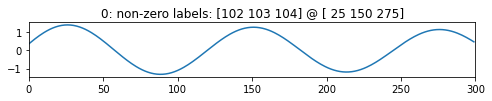

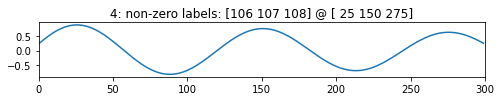

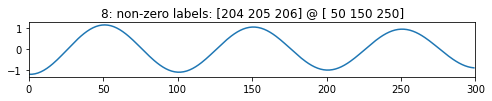

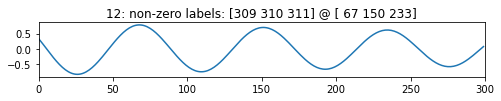

In [ ]:
X_win, y_win = preprocess_sliding_event_window(X, y, events, width=300, limit=5, has_label_per_sample=True)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')
for i in range(0, len(X_win), 4):
    sig = X_win[i]
    yy =  y_win[i]
    assert sig.shape == yy.shape
    
    yy_pos = np.where(yy>0)[0]
    yy_subset =  yy[yy>0]
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: non-zero labels: {yy_subset} @ {yy_pos}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show() 

#### Example: Splits

In [ ]:
# generate data with splits
X, y, events, splits = get_sample_data(length=1000, n_sig=20, split_pct=(0.2, 0.15))
test_eq(len(splits), 3)
splits

(#3) [[1, 2, 4, 5, 6, 10, 11, 12, 14, 16, 17, 19],[3, 7, 9, 13],[0, 8, 15, 18]]

In [ ]:
X_win, y_win, splits_win = preprocess_sliding_event_window(X, y, events, width=150, limit=2, splits=splits)
test_eq(len(splits_win), 3)
splits_win

(#3) [[2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 28, 29, 32, 33, 34, 35, 38, 39],[6, 7, 14, 15, 18, 19, 26, 27],[0, 1, 16, 17, 30, 31, 36, 37]]

#### Example: Folds

In [ ]:
# generate data with folds
X, y, events, folds = get_sample_data(length=1000, n_sig=20, n_fold=5)
folds

array([0, 2, 4, 1, 3, 0, 4, 1, 1, 1, 4, 3, 4, 2, 3, 2, 3, 0, 0, 2])

In [ ]:
X_win, y_win, folds_win = preprocess_sliding_event_window(X, y, events, width=150, limit=2, folds=folds)
folds_win

array([0, 0, 2, 2, 4, 4, 1, 1, 3, 3, 0, 0, 4, 4, 1, 1, 1, 1, 1, 1, 4, 4,
       3, 3, 4, 4, 2, 2, 3, 3, 2, 2, 3, 3, 0, 0, 0, 0, 2, 2])